In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.table import Table
import numpy as np
from matplotlib.colors import SymLogNorm
import stuff

from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

keras.backend.set_image_data_format('channels_first')

# Preamble

In [2]:
catalog = Table.read('/home/aalvarez/Work/Data/sim12/sim12_cat.fits', hdu=1)
catalog['vignet'][np.isnan(catalog['vignet'])] = 0.
snr = ((catalog['isophotal_flux'] / catalog['isophotal_flux_err']) >= 10) & (catalog['auto_flags'] == 0)
catalog = catalog[snr]

In [3]:
sim = stuff.Simulation('/home/aalvarez/Work/Data/sim12/sim12.list', mag_zeropoint=26, exposure=300)

In [4]:
closest = sim.get_closest(catalog['world_centroid_alpha'], catalog['world_centroid_delta'])

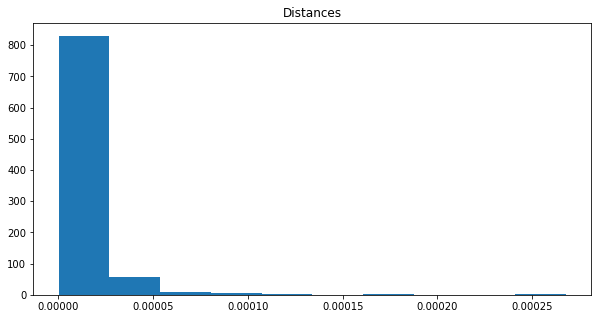

In [5]:
plt.figure(figsize=(10,5))
plt.hist(closest.distance)
plt.title('Distances')
plt.show()

# Prepare dataset

In [7]:
labels = closest.is_galaxy.astype(np.float).reshape(-1, 1)

images = np.array(catalog['vignet'].data, copy=True)
images = images.reshape(-1, 1, 32, 32)

In [8]:
train_X, test_X, train_Y, test_Y = train_test_split(images, labels, test_size=0.2)

<ipython-input-9-9bbbaf13085a>:8: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  ax.imshow(imgs[i,0], cmap='Greys_r', norm=SymLogNorm(10))


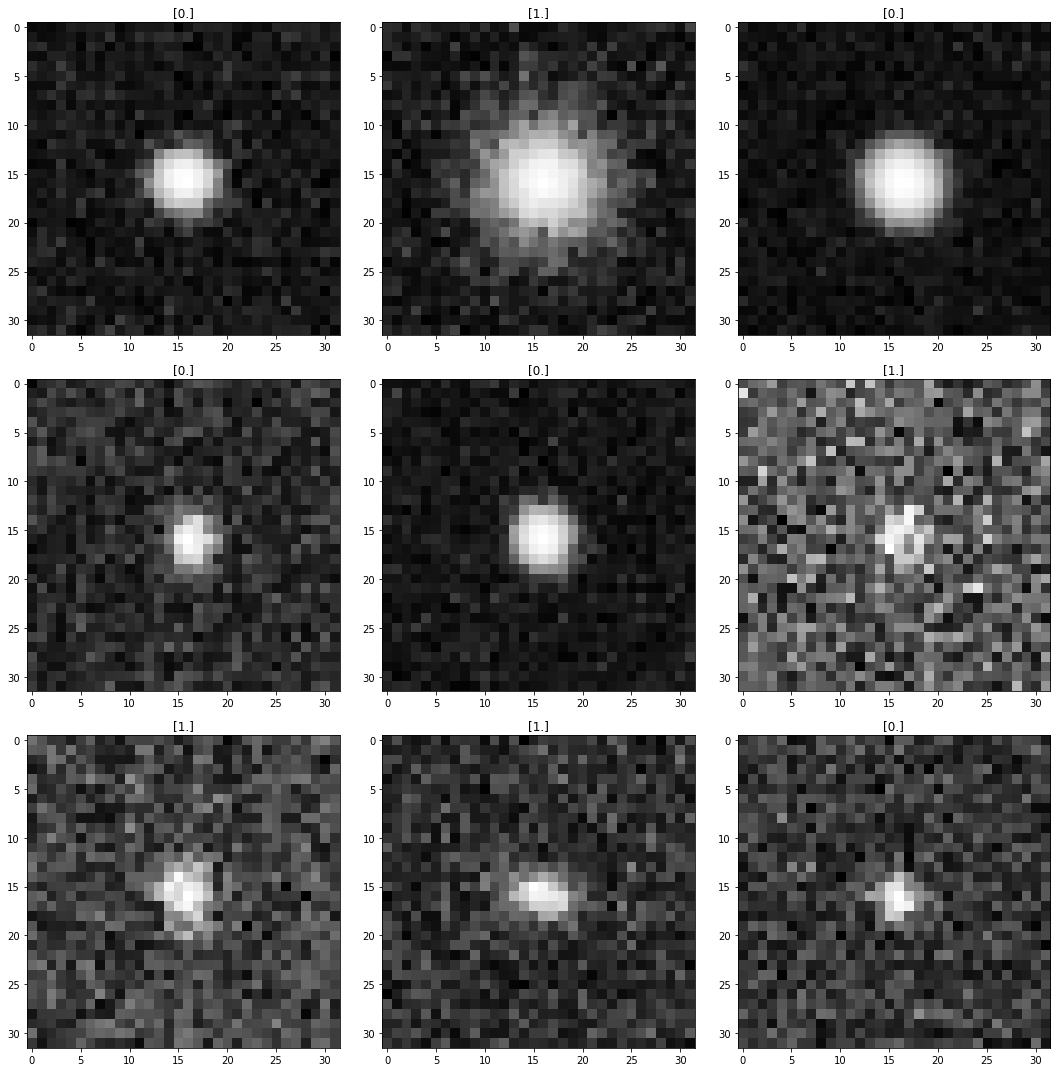

In [9]:
def plot_some(imgs, labels, n=9):
    nrows = n // 3 + (n % 3)
    
    idx = np.random.choice(len(imgs), n)
    
    fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15, 15))
    for i, ax in zip(idx, axes.ravel()):
        ax.imshow(imgs[i,0], cmap='Greys_r', norm=SymLogNorm(10))
        ax.set_title(str(labels[i]))
    plt.tight_layout()

plot_some(train_X, train_Y)

In [10]:
len(train_X)

724

# Training

In [11]:
model = keras.Sequential([
    layers.Input(train_X[0].shape),
    layers.BatchNormalization(),
    layers.Conv2D(8, kernel_size=3, padding='same'),
    #layers.BatchNormalization(),
    layers.Activation('tanh'),
    layers.MaxPooling2D(3),
    layers.Conv2D(16, kernel_size=(5, 5), padding='same'),
    #layers.BatchNormalization(),
    layers.Activation('tanh'),
    layers.MaxPooling2D(3),
    layers.Flatten(),
    layers.Dense(64),
    layers.Dropout(0.01),
    layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 1, 32, 32)         128       
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 32, 32)         80        
_________________________________________________________________
activation (Activation)      (None, 8, 32, 32)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 10, 10)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 10)        3216      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 10, 10)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 3, 3)          0

In [12]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [53]:
model.fit(train_X, train_Y, batch_size=64, epochs=10)

Epoch 1/10
12/12 [==============================] - 0s 4ms/step - loss: 0.1151 - accuracy: 0.9461
Epoch 2/10
12/12 [==============================] - 0s 4ms/step - loss: 0.0789 - accuracy: 0.9738
Epoch 3/10
12/12 [==============================] - 0s 3ms/step - loss: 0.0896 - accuracy: 0.9613
Epoch 4/10
12/12 [==============================] - 0s 3ms/step - loss: 0.1380 - accuracy: 0.9365
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.1211 - accuracy: 0.9392
Epoch 6/10
12/12 [==============================] - 0s 4ms/step - loss: 0.0962 - accuracy: 0.9503
Epoch 7/10
12/12 [==============================] - 0s 4ms/step - loss: 0.0651 - accuracy: 0.9793
Epoch 8/10
12/12 [==============================] - 0s 3ms/step - loss: 0.0713 - accuracy: 0.9724
Epoch 9/10
12/12 [==============================] - 0s 4ms/step - loss: 0.0962 - accuracy: 0.9572
Epoch 10/10
12/12 [==============================] - 0s 4ms/step - loss: 0.0688 - accuracy: 0.9765


In [54]:
model.evaluate(train_X, train_Y)

23/23 [==============================] - 0s 2ms/step - loss: 0.3035 - accuracy: 0.8660


[0.30350837111473083, 0.8660221099853516]

In [55]:
model.evaluate(test_X, test_Y)

6/6 [==============================] - 0s 1ms/step - loss: 0.4256 - accuracy: 0.8352


[0.42555853724479675, 0.8351648449897766]

In [56]:
bad = ((model.predict(test_X) >= 0.5) != test_Y).reshape(-1)

<ipython-input-9-9bbbaf13085a>:8: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  ax.imshow(imgs[i,0], cmap='Greys_r', norm=SymLogNorm(10))


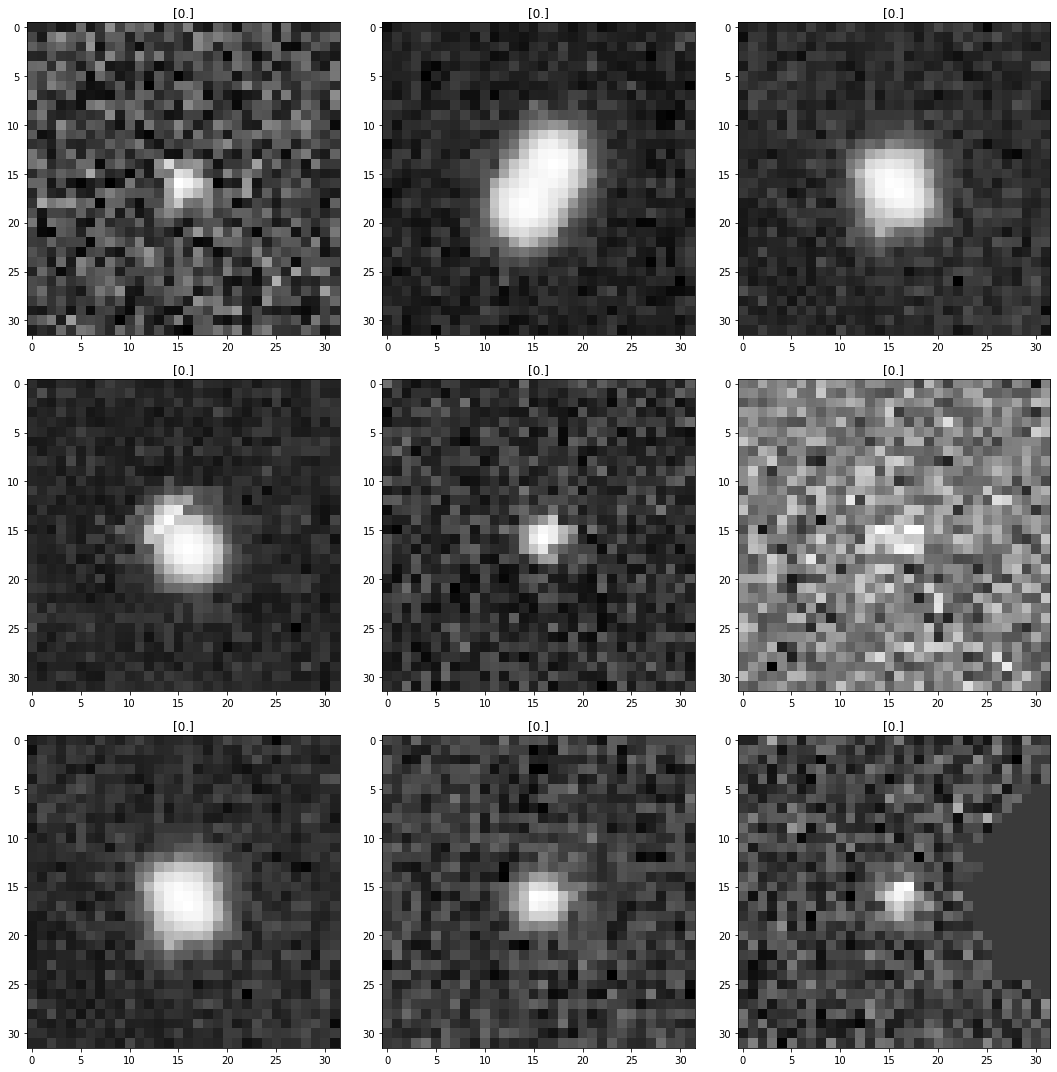

In [57]:
plot_some(test_X[bad], test_Y[bad])

# To ONNX

In [58]:
import keras2onnx

In [59]:
model_copy = keras.models.clone_model(model)
model_copy.set_weights(model.get_weights())
model_copy.add(keras.layers.Lambda(lambda x: keras.backend.cast(x >= 0.5, dtype='int32'), name='is_galaxy'))

In [60]:
int_pred = model_copy.predict(train_X)
print(int_pred.reshape(-1))
print((int_pred == train_Y.astype(np.int)).sum() / len(train_X))

[1 0 1 0 1 1 0 0 1 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1
 0 0 0 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 0 1 1 0 1 0 0 1 0 0 0 0 1 1 0 1
 0 1 1 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 1 0 1 0 0 0 1
 1 1 1 1 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 1 0
 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 0 1 1
 1 0 1 0 0 1 0 1 1 0 0 0 1 0 1 0 1 0 1 1 0 0 1 1 1 1 0 1 0 0 1 0 0 1 0 1 1
 0 0 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1
 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1
 1 0 0 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0 1 0 1 0 1 1 0 0 1 1 1
 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1
 0 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 1 0 0 0 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1
 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 0 1 0 0 0 1 1 1 1 0 0 0 1 1 1 1 1 1 0 1 0
 1 1 1 1 0 1 0 1 0 0 1 1 

In [61]:
onnx_model = keras2onnx.convert_keras(model_copy, name='IsGalaxy')

tf executing eager_mode: True
tf.keras model eager_mode: False
The ONNX operator number change on the optimization: 31 -> 18


In [62]:
onnx_model.domain = 'ch.unige.astro'

In [63]:
keras2onnx.save_model(onnx_model, '/home/aalvarez/Work/Data/sim14/is_gal.onnx')